<a href="https://colab.research.google.com/github/Elimirage/digital_image_processing_24vvim1/blob/main/lab2/LB3_Yumaeva_DIP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [180]:
import numpy as np
import cv2 as cv

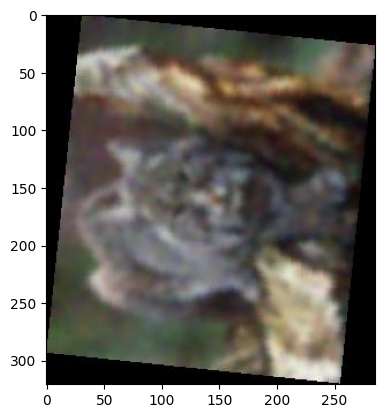

In [181]:
image = cv.imread('/content/Image-97-869ef3.jpg')
rgb_image = cv.cvtColor(image, cv.COLOR_BGR2RGB)
plt.imshow(rgb_image)

[[ 1.04528463e-01 -9.94521895e-01  2.87175933e+02]
 [ 9.94521895e-01  1.04528463e-01  1.05881484e+00]]


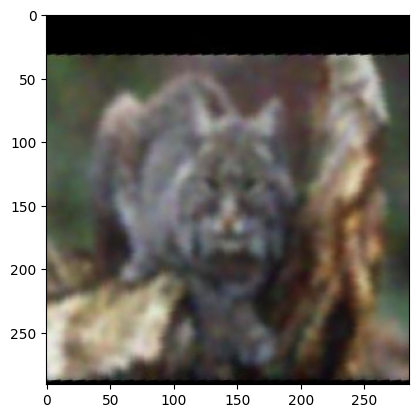

In [197]:
(h, w, d) = rgb_image.shape
angle = -84
scale = 1.0
center = (w // 2, h // 2)
M = cv.getRotationMatrix2D(center, angle, scale)
print(M)
rotated = cv.warpAffine(rgb_image, M, (w, h-30))
plt.imshow(rotated)

In [159]:
def add_gauss_noise(image, mean, sigma):
    image = np.array(image / 255, dtype=float)
    noise = np.random.normal(mean, sigma, image.shape)
    noisy_image = image + noise
    out = np.clip(noisy_image, 0, 1.0)
    out = np.uint8(out * 255)
    return out


def add_salt_and_peper_noise(im, fraction=0.01):
    assert (0 < fraction <= 1.), "Fraction must be in (0, 1]"

    if len(im.shape) == 3:
      sp = np.zeros(im.shape)
      percent = round(fraction * 100 / 2.)

      cv.randu(sp, 0, 100)
      sp[:,:,1] = sp[:,:,0]
      sp[:,:,2] = sp[:,:,0]

      im_sp = im.copy()
      im_sp[sp < percent] = 0
      im_sp[sp > 100 - percent] = 255
      return im_sp

    if len(im.shape) == 2:
      sp = np.zeros(im.shape)
      percent = round(fraction * 100 / 2.)

      cv.randu(sp, 0, 100)

      im_sp = im.copy()
      im_sp[sp < percent] = 0
      im_sp[sp > 100 - percent] = 255
      return im_sp

In [160]:
def getSSIM(i1, i2):
    C1 = 6.5025  # для 8-битного изоражения
    C2 = 58.5225  # для 8-битного изоражения
    # INITS
    I1 = np.float32(i1)
    I2 = np.float32(i2)
    I2_2 = I2 * I2  # I2^2
    I1_2 = I1 * I1  # I1^2
    I1_I2 = I1 * I2  # I1 * I2

    mu1 = cv.GaussianBlur(I1, (11, 11), 1.5)
    mu2 = cv.GaussianBlur(I2, (11, 11), 1.5)
    mu1_2 = mu1 * mu1
    mu2_2 = mu2 * mu2
    mu1_mu2 = mu1 * mu2
    sigma1_2 = cv.GaussianBlur(I1_2, (11, 11), 1.5)
    sigma1_2 -= mu1_2
    sigma2_2 = cv.GaussianBlur(I2_2, (11, 11), 1.5)
    sigma2_2 -= mu2_2
    sigma12 = cv.GaussianBlur(I1_I2, (11, 11), 1.5)
    sigma12 -= mu1_mu2
    t1 = 2 * mu1_mu2 + C1
    t2 = 2 * sigma12 + C2
    t3 = t1 * t2  # t3 = ((2*mu1_mu2 + C1).*(2*sigma12 + C2))
    t1 = mu1_2 + mu2_2 + C1
    t2 = sigma1_2 + sigma2_2 + C2
    t1 = t1 * t2  # t1 =((mu1_2 + mu2_2 + C1).*(sigma1_2 + sigma2_2 + C2))
    ssim_map = cv.divide(t3, t1)  # ssim_map =  t3./t1;
    ssim = cv.mean(ssim_map)  # mssim = average of ssim map
    ssim = ssim[:3]
    return ssim

In [161]:
def getPSNR(I1, I2):
    s1 = cv.absdiff(I1, I2)  #|I1 - I2| - модуль разницы двух изображений
    s1 = np.float32(s1)
    s1 = s1 * s1  # |I1 - I2|^2
    sse = s1.sum()  # сумма элементов в каждом канале
    if sse <= 1e-10:  # сумма каналов
        return 0
    else:
        shape = I1.shape
        p=1
        for i in shape:
          p *= i
        mse = 1.0 * sse /p
        psnr = 10.0 * np.log10((255 * 255) / mse)
        return psnr

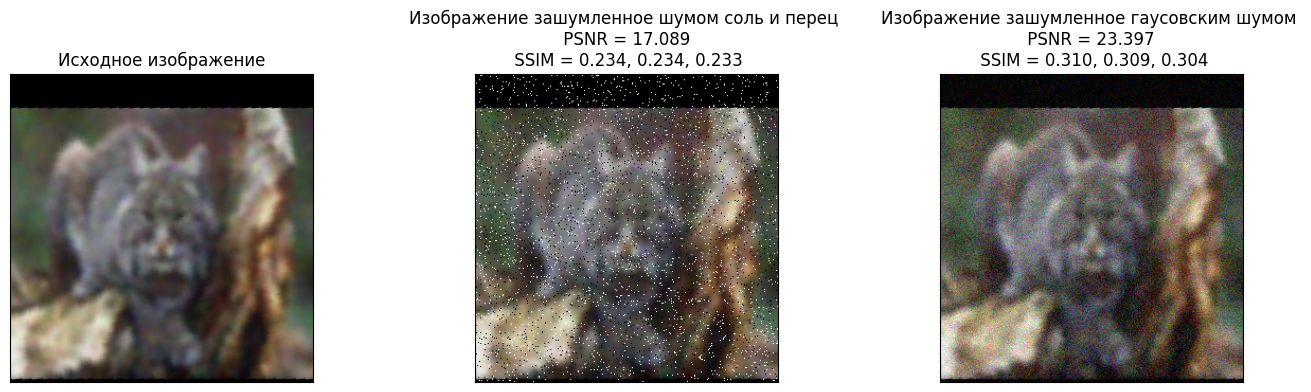

In [214]:
gs = plt.GridSpec(1, 3)
plt.figure(figsize=(17, 4))

plt.subplot(gs[0])
plt.title('Исходное изображение')
plt.xticks([]), plt.yticks([])
plt.imshow(rotated)

plt.subplot(gs[1])
plt.xticks([]), plt.yticks([])
noisy_image = add_salt_and_peper_noise(rotated, 0.06)
psnr = getPSNR(rotated, noisy_image)
ssim = getSSIM(rotated, noisy_image)
plt.title(f'Изображение зашумленное шумом соль и перец \n PSNR = {psnr:.3f} \n SSIM = {ssim[0]:.3f}, {ssim[1]:.3f}, {ssim[2]:.3f}')
plt.imshow(noisy_image)

plt.subplot(gs[2])
plt.xticks([]), plt.yticks([])
noisy_image = add_gauss_noise(rotated, 0, 0.07)
psnr = getPSNR(rotated, noisy_image)
ssim = getSSIM(rotated, noisy_image)
plt.title(f'Изображение зашумленное гаусовским шумом \n PSNR = {psnr:.3f} \n SSIM = {ssim[0]:.3f}, {ssim[1]:.3f}, {ssim[2]:.3f}')
plt.imshow(noisy_image, 'gray')
plt.show()

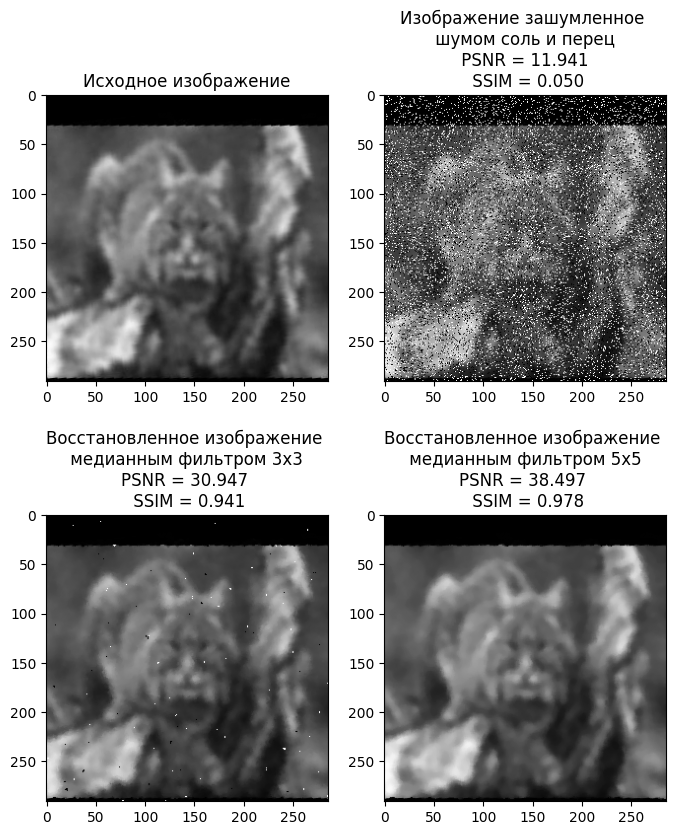

In [218]:
gray_image1 = cv.cvtColor(rotated, cv.COLOR_BGR2GRAY)
sap_image1 = add_salt_and_peper_noise(gray_image1, 0.2)
median_image1 = cv.medianBlur(sap_image1, 3)
median_image2 = cv.medianBlur(sap_image1, 5)
gs = plt.GridSpec(2, 2)
plt.figure(figsize=(8, 10))
plt.subplot(gs[0])
plt.imshow(gray_image1, cmap='gray')
plt.title('Исходное изображение')
plt.subplot(gs[1])
plt.imshow(sap_image1, cmap='gray')
psnr = getPSNR(gray_image1, sap_image1)
ssim = getSSIM(gray_image1, sap_image1)
plt.title(f'Изображение зашумленное \n шумом соль и перец \n PSNR = {psnr:.3f} \n SSIM = {ssim[0]:.3f}')
plt.subplot(gs[2])
plt.imshow(median_image1, cmap='gray')
psnr = getPSNR(gray_image1, median_image1)
ssim = getSSIM(gray_image1, median_image1)
plt.title(f'Восстановленное изображение \n '
          f'медианным фильтром 3х3 \n'
          f'PSNR = {psnr:.3f} \n SSIM = {ssim[0]:.3f}')

plt.subplot(gs[3])
plt.imshow(median_image2, cmap='gray')
psnr = getPSNR(gray_image1, median_image2)
ssim = getSSIM(gray_image1, median_image2)
plt.title(f'Восстановленное изображение \n '
          f'медианным фильтром 5х5 \n'
          f'PSNR = {psnr:.3f} \n SSIM = {ssim[0]:.3f}')

plt.show()

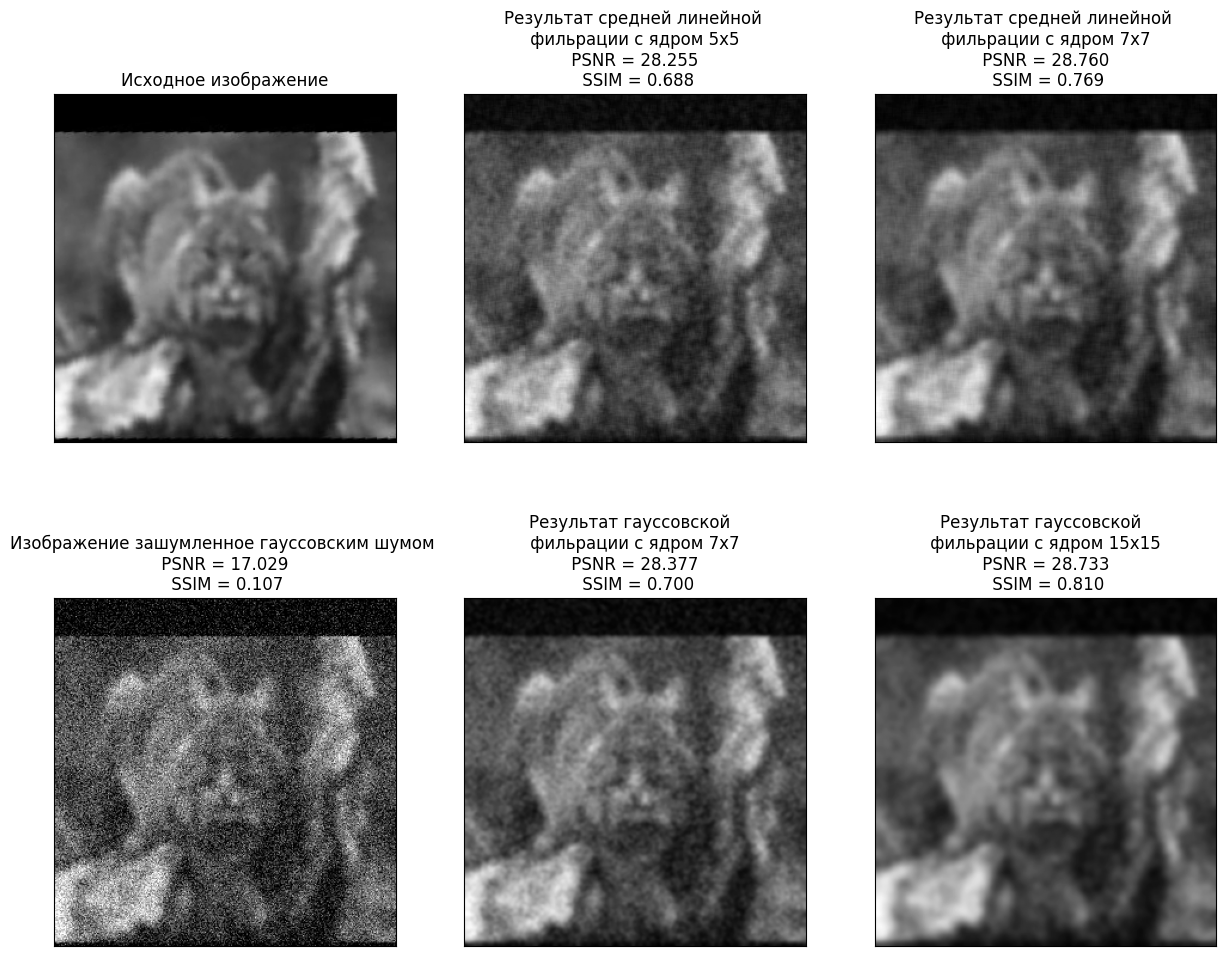

In [226]:
kernel55 = np.ones((5, 5), np.float32) / 25
kernel77 = np.ones((7, 7), np.float32) / 49

noisy_image = add_gauss_noise(gray_image1, 0, 0.15)

filtered_image1 = cv.filter2D(noisy_image, -1, kernel55)
filtered_image2 = cv.filter2D(noisy_image, -1, kernel77)
gaussian_image1 = cv.GaussianBlur(noisy_image, (7, 7), 0)
gaussian_image2 = cv.GaussianBlur(noisy_image, (15, 15), 0)

# вывод
gs = plt.GridSpec(2, 3)
plt.figure(figsize=(15, 12))

plt.subplot(gs[0, 0])
plt.xticks([]), plt.yticks([])
plt.title('Исходное изображение')
plt.imshow(gray_image1, cmap='gray')

plt.subplot(gs[1, 0])
plt.xticks([]), plt.yticks([])
plt.imshow(noisy_image, cmap='gray')
psnr = getPSNR(gray_image1, noisy_image)
ssim = getSSIM(gray_image1, noisy_image)
plt.title(f'Изображение зашумленное гауссовским шумом \n PSNR = {psnr:.3f} \n SSIM = {ssim[0]:.3f}')

plt.subplot(gs[0, 1])
plt.xticks([]), plt.yticks([])
plt.title(f'Результат средней линейной \n фильрации с ядром 5х5 \n '
          f'PSNR = {getPSNR(gray_image1, filtered_image1):.3f} \n '
          f'SSIM = {getSSIM(gray_image1, filtered_image1)[0]:.3f}')
plt.imshow(filtered_image1, 'gray')

plt.subplot(gs[0, 2])
plt.xticks([]), plt.yticks([])
plt.title(f'Результат средней линейной \n фильрации с ядром 7х7 \n '
          f'PSNR = {getPSNR(gray_image1, filtered_image2):.3f} \n '
          f'SSIM = {getSSIM(gray_image1, filtered_image2)[0]:.3f}')
plt.imshow(filtered_image2, 'gray')

plt.subplot(gs[1, 1])
plt.xticks([]), plt.yticks([])
plt.title(f'Результат гауссовской  \n фильрации с ядром 7х7 \n '
          f'PSNR = {getPSNR(gray_image1, gaussian_image1):.3f} \n '
          f'SSIM = {getSSIM(gray_image1, gaussian_image1)[0]:.3f}')
plt.imshow(gaussian_image1, 'gray')

plt.subplot(gs[1, 2])
plt.xticks([]), plt.yticks([])
plt.title(f'Результат гауссовской  \n фильрации с ядром 15х15 \n '
          f'PSNR = {getPSNR(gray_image1, gaussian_image2):.3f} \n '
          f'SSIM = {getSSIM(gray_image1, gaussian_image2)[0]:.3f}')
plt.imshow(gaussian_image2, 'gray')

plt.show()

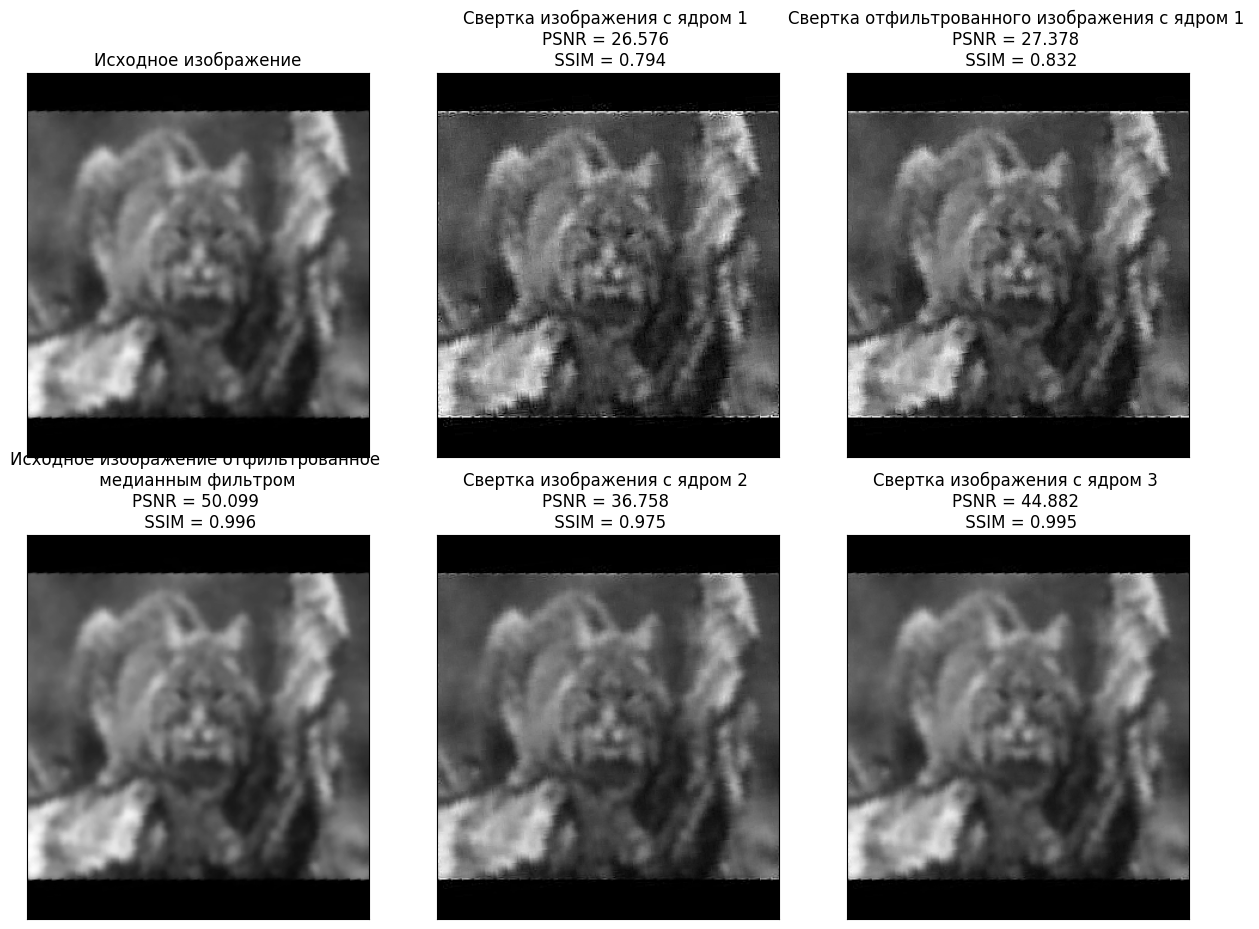

In [165]:
kernel1 = np.asarray([[-1, -1, -1], [-1, 9, -1], [-1, -1, -1]])
kernel2 = np.asarray([[-0.25, -0.25, -0.25], [-0.25, 3, -0.25], [-0.25, -0.25, -0.25]])
kernel3 = np.asarray([[0, -0.25, 0], [-0.25, 2, -0.25], [0, -0.25, 0]])

gray_image1_median = cv.medianBlur(gray_image1, 3)

filtered_image1 = cv.filter2D(gray_image1, -1, kernel1)
filtered_image1_median = cv.filter2D(gray_image1_median, -1, kernel1)
filtered_image2 = cv.filter2D(gray_image1, -1, kernel2)
filtered_image2_median = cv.filter2D(gray_image1_median, -1, kernel2)
filtered_image3 = cv.filter2D(gray_image1, -1, kernel3)
filtered_image3_median = cv.filter2D(gray_image1_median, -1, kernel3)

# вывод
plt.figure(figsize=(15, 17))

plt.subplot(331)
plt.xticks([]), plt.yticks([])
plt.title('Исходное изображение')
plt.imshow(gray_image1, cmap='gray')

plt.subplot(334)
plt.xticks([]), plt.yticks([])
plt.title(f'Исходное изображение отфильтрованное \n медианным фильтром \n'
          f'PSNR = {getPSNR(gray_image1, gray_image1_median):.3f} \n '
          f'SSIM = {getSSIM(gray_image1, gray_image1_median)[0]:.3f}')
plt.imshow(gray_image1_median, cmap='gray')

plt.subplot(332)
plt.xticks([]), plt.yticks([])
plt.title(f'Свертка изображения с ядром 1 \n'
          f'PSNR = {getPSNR(gray_image1, filtered_image1):.3f} \n '
          f'SSIM = {getSSIM(gray_image1, filtered_image1)[0]:.3f}')
plt.imshow(filtered_image1, 'gray')

plt.subplot(333)
plt.xticks([]), plt.yticks([])
plt.title(f'Свертка отфильтрованного изображения с ядром 1 \n'
          f'PSNR = {getPSNR(gray_image1, filtered_image1_median):.3f} \n '
          f'SSIM = {getSSIM(gray_image1, filtered_image1_median)[0]:.3f}')
plt.imshow(filtered_image1_median, 'gray')

plt.subplot(335)
plt.xticks([]), plt.yticks([])
plt.title(f'Свертка изображения с ядром 2 \n'
          f'PSNR = {getPSNR(gray_image1, filtered_image2):.3f} \n '
          f'SSIM = {getSSIM(gray_image1, filtered_image2)[0]:.3f}')
plt.imshow(filtered_image2, 'gray')

plt.subplot(336)
plt.xticks([]), plt.yticks([])
plt.title(f'Свертка изображения с ядром 3 \n'
          f'PSNR = {getPSNR(gray_image1, filtered_image3):.3f} \n '
          f'SSIM = {getSSIM(gray_image1, filtered_image3)[0]:.3f}')
plt.imshow(filtered_image3, 'gray')

plt.show()

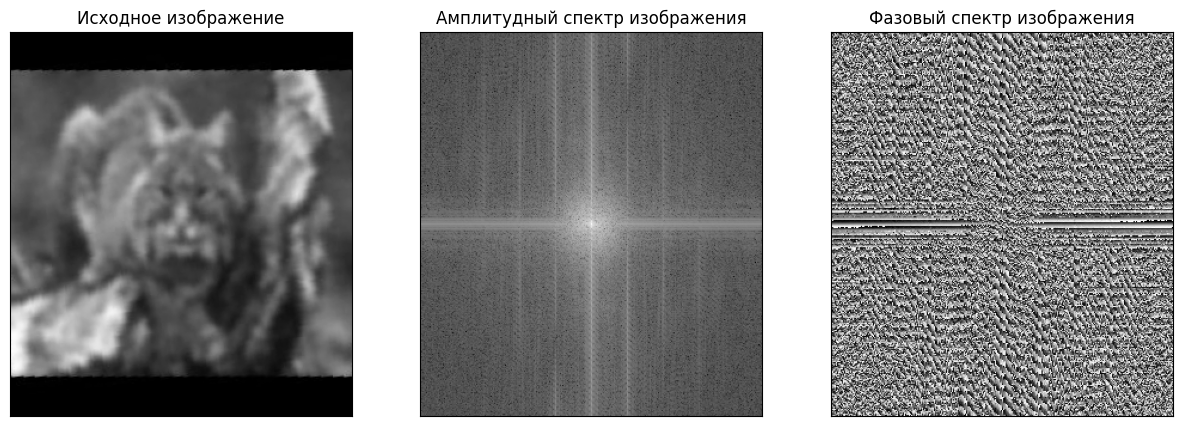

In [166]:
import cv2 as cv
import numpy as np
from matplotlib import pyplot as plt


gray_img = cv.cvtColor(rotated, cv.COLOR_BGR2GRAY)
f = np.fft.fft2(gray_img)
fshift = np.complex64(np.fft.fftshift(f))
magnitude_spectrum = 20 * np.log(np.abs(fshift))
phase_spectrum = np.uint8(255 * (np.angle(fshift) + np.pi) / (2 * np.pi))

# вывод
plt.figure(figsize=(15, 12))
plt.subplot(131), plt.imshow(gray_img, cmap='gray')
plt.title('Исходное изображение'), plt.xticks([]), plt.yticks([])
plt.subplot(132), plt.imshow(magnitude_spectrum, cmap='gray')
plt.title('Амплитудный спектр изображения'), plt.xticks([]), plt.yticks([])
plt.subplot(133), plt.imshow(phase_spectrum, cmap='gray')
plt.title('Фазовый спектр изображения'), plt.xticks([]), plt.yticks([])
plt.show()

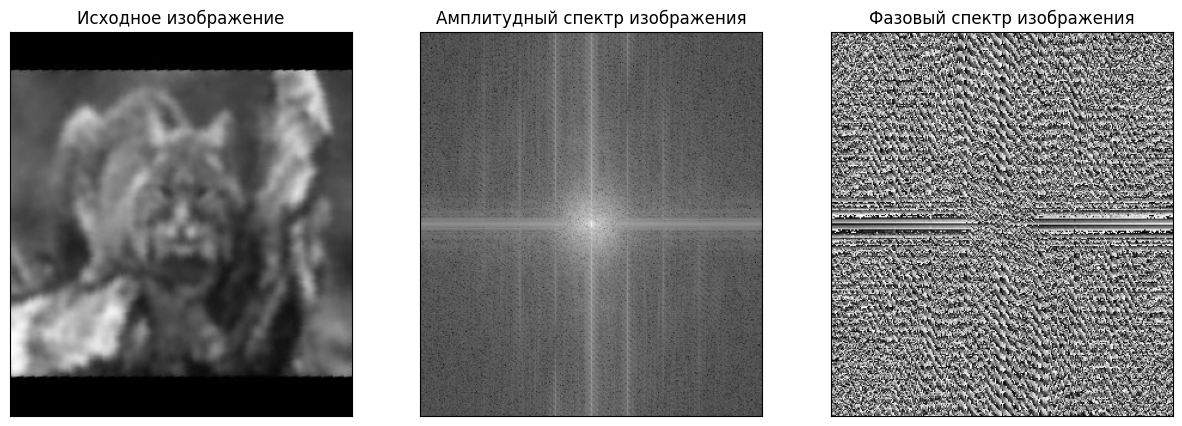

In [167]:
dft = cv.dft(np.float32(gray_img), flags=cv.DFT_COMPLEX_OUTPUT)
dft_shift = np.fft.fftshift(dft)
magnitude_spectrum = 20 * np.log(cv.magnitude(dft_shift[..., 0], dft_shift[..., 1]))
phase_spectrum = cv.phase(dft_shift[..., 1], dft_shift[..., 0])
# вывод
plt.figure(figsize=(15, 15))
plt.subplot(131), plt.imshow(gray_img, cmap='gray')
plt.title('Исходное изображение'), plt.xticks([]), plt.yticks([])
plt.subplot(132), plt.imshow(magnitude_spectrum, cmap='gray')
plt.title('Амплитудный спектр изображения'), plt.xticks([]), plt.yticks([])
plt.subplot(133), plt.imshow(phase_spectrum, cmap='gray')
plt.title('Фазовый спектр изображения'), plt.xticks([]), plt.yticks([])
plt.show()

/tmp/ipython-input-3368131363.py:20: RuntimeWarning: divide by zero encountered in log
  magnitude_dft_shift_masked = 20 * np.log(


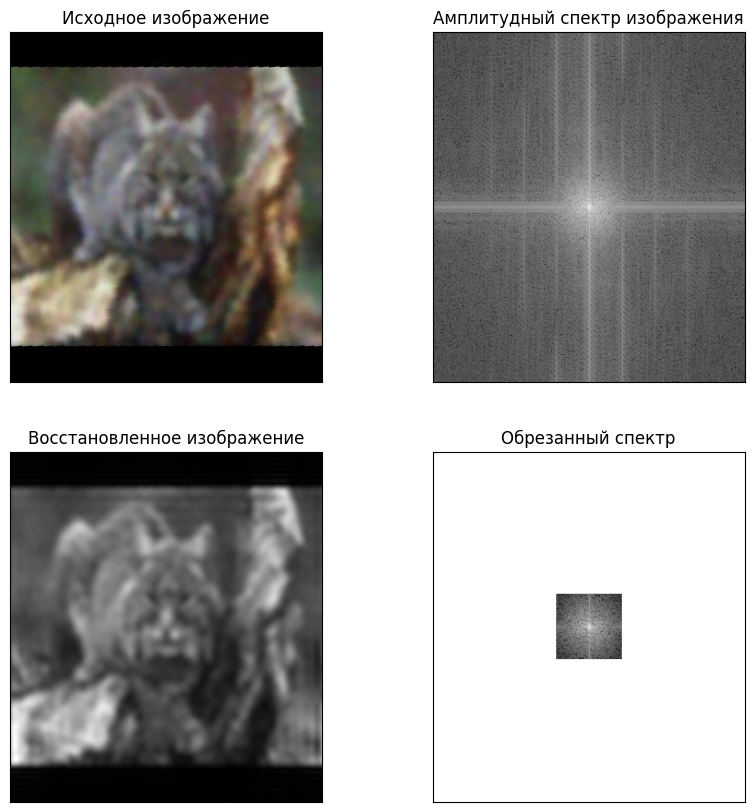

In [168]:
r = 30
rows, cols = gray_img.shape
crow, ccol = np.uint32((rows / 2, cols / 2))
# create a mask first, center square is 1, remaining all zeros
mask = np.zeros((rows, cols, 2), np.uint8)
mask[crow - r:crow + r, ccol - r:ccol + r] = 1

# вычисляем фурье-образ
dft = cv.dft(np.float32(gray_img), flags=cv.DFT_COMPLEX_OUTPUT)
dft_shift = np.fft.fftshift(dft)

# применяем маску и делаем обратное преобразование Фурье
dft_shift_masked = dft_shift * mask
f_ishift = np.fft.ifftshift(dft_shift_masked)
img_back = cv.idft(f_ishift)
img_back = cv.magnitude(img_back[..., 0], img_back[..., 1])

magnitude_dft_shift = 20 * np.log(
    cv.magnitude(dft_shift[..., 0], dft_shift[..., 1]))
magnitude_dft_shift_masked = 20 * np.log(
    cv.magnitude(dft_shift_masked[..., 0], dft_shift_masked[..., 1]))

# вывод
plt.figure(figsize=(10, 10))
plt.subplot(221), plt.imshow(rotated, cmap='gray')
plt.title('Исходное изображение'), plt.xticks([]), plt.yticks([])
plt.subplot(222), plt.imshow(magnitude_dft_shift, cmap='gray')
plt.title('Амплитудный спектр изображения'), plt.xticks([]), plt.yticks([])
plt.subplot(223), plt.imshow(img_back, cmap='gray')
plt.title('Восстановленное изображение'), plt.xticks([]), plt.yticks([])
plt.subplot(224), plt.imshow(magnitude_dft_shift_masked, cmap='gray')
plt.title('Обрезанный спектр'), plt.xticks([]), plt.yticks([])
plt.show()

/tmp/ipython-input-3892159024.py:20: RuntimeWarning: divide by zero encountered in log
  magnitude_dft_shift_masked = 20 * np.log(


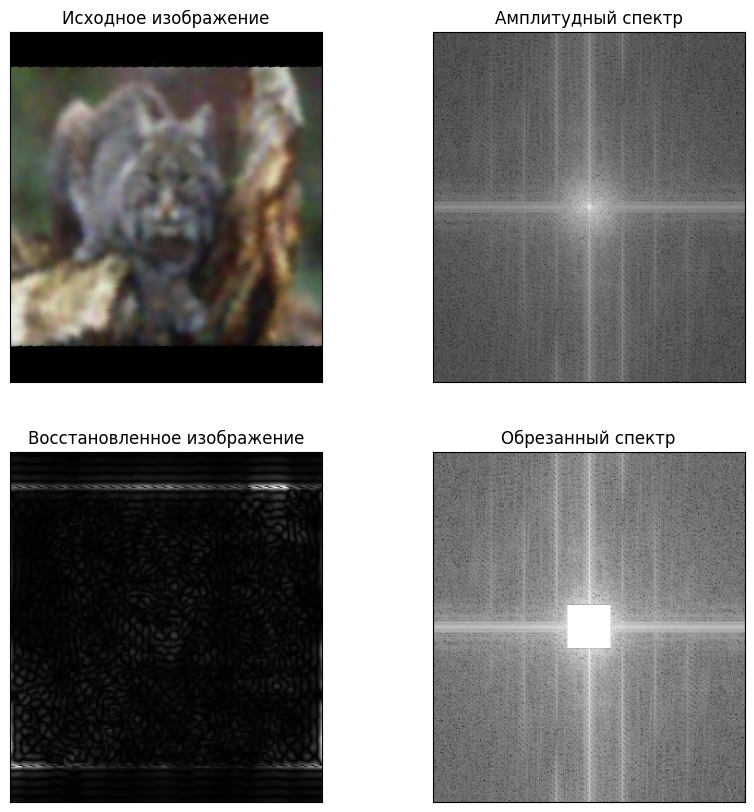

In [169]:
r = 20
rows, cols = gray_img.shape
crow, ccol = np.uint32((rows / 2, cols / 2))
# create a mask first, center square is 1, remaining all zeros
mask = np.ones((rows, cols, 2), np.uint8)
mask[crow - r:crow + r, ccol - r:ccol + r] = 0

# вычисляем фурье-образ
dft = cv.dft(np.float32(gray_img), flags=cv.DFT_COMPLEX_OUTPUT)
dft_shift = np.fft.fftshift(dft)

# применяем маску и делаем обратное преобразование Фурье
dft_shift_masked = dft_shift * mask
f_ishift = np.fft.ifftshift(dft_shift_masked)
img_back = cv.idft(f_ishift)
img_back = cv.magnitude(img_back[..., 0], img_back[..., 1])

magnitude_dft_shift = 20 * np.log(
    cv.magnitude(dft_shift[..., 0], dft_shift[..., 1]))
magnitude_dft_shift_masked = 20 * np.log(
    cv.magnitude(dft_shift_masked[..., 0], dft_shift_masked[..., 1]))

# вывод
plt.figure(figsize=(10, 10))
plt.subplot(221), plt.imshow(rotated, cmap='gray')
plt.title('Исходное изображение'), plt.xticks([]), plt.yticks([])
plt.subplot(222), plt.imshow(magnitude_dft_shift, cmap='gray')
plt.title('Амплитудный спектр'), plt.xticks([]), plt.yticks([])
plt.subplot(223), plt.imshow(img_back, cmap='gray')
plt.title('Восстановленное изображение'), plt.xticks([]), plt.yticks([])
plt.subplot(224), plt.imshow(magnitude_dft_shift_masked, cmap='gray')
plt.title('Обрезанный спектр'), plt.xticks([]), plt.yticks([])
plt.show()
